# EfficientNetV2S - mixed augmentation pipeline


Things we've done:
- Data cleaning (No Shrek nor Rick)
- Data augmentation in learning phase using a mixed pipeline
- Class weights
- Batch normalization
- Dropout
- L2 regularization (L2)
- Adam optimizer
- Early stopping
- Learning Grade Decay

In [ ]:
# Install python 3.11
!mamba create -n py311 -y
!source /opt/conda/bin/activate py311 && mamba install python=3.11 jupyter mamba -y

!sudo rm /opt/conda/bin/python3
!sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python3
!sudo rm /opt/conda/bin/python3.7
!sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python3.7
!sudo rm /opt/conda/bin/python
!sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python

In [1]:
!python --version

Python 3.11.10


In [ ]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

In [ ]:
!pip install keras_cv

In [ ]:
!pip install -r requirements.txt

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


In [3]:
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


# Load Data

**Load the cleaned dataset:** The dataset has been cleaned by removing dirty images containing Shrek and Rick Astley, using data exploration notebook 

In [4]:
# Load the .npz File
data = np.load('/kaggle/input/bloodcells/clean_training_set.npz')

# Extract Images and Labels
images = data['images']
labels = data['labels']

# Verify the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)


In [5]:
# Define input and output dimensions
input_shape = (96, 96, 3)
output_shape = 8

In [ ]:
label_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

# Data exploration

Show 10 samples for each class

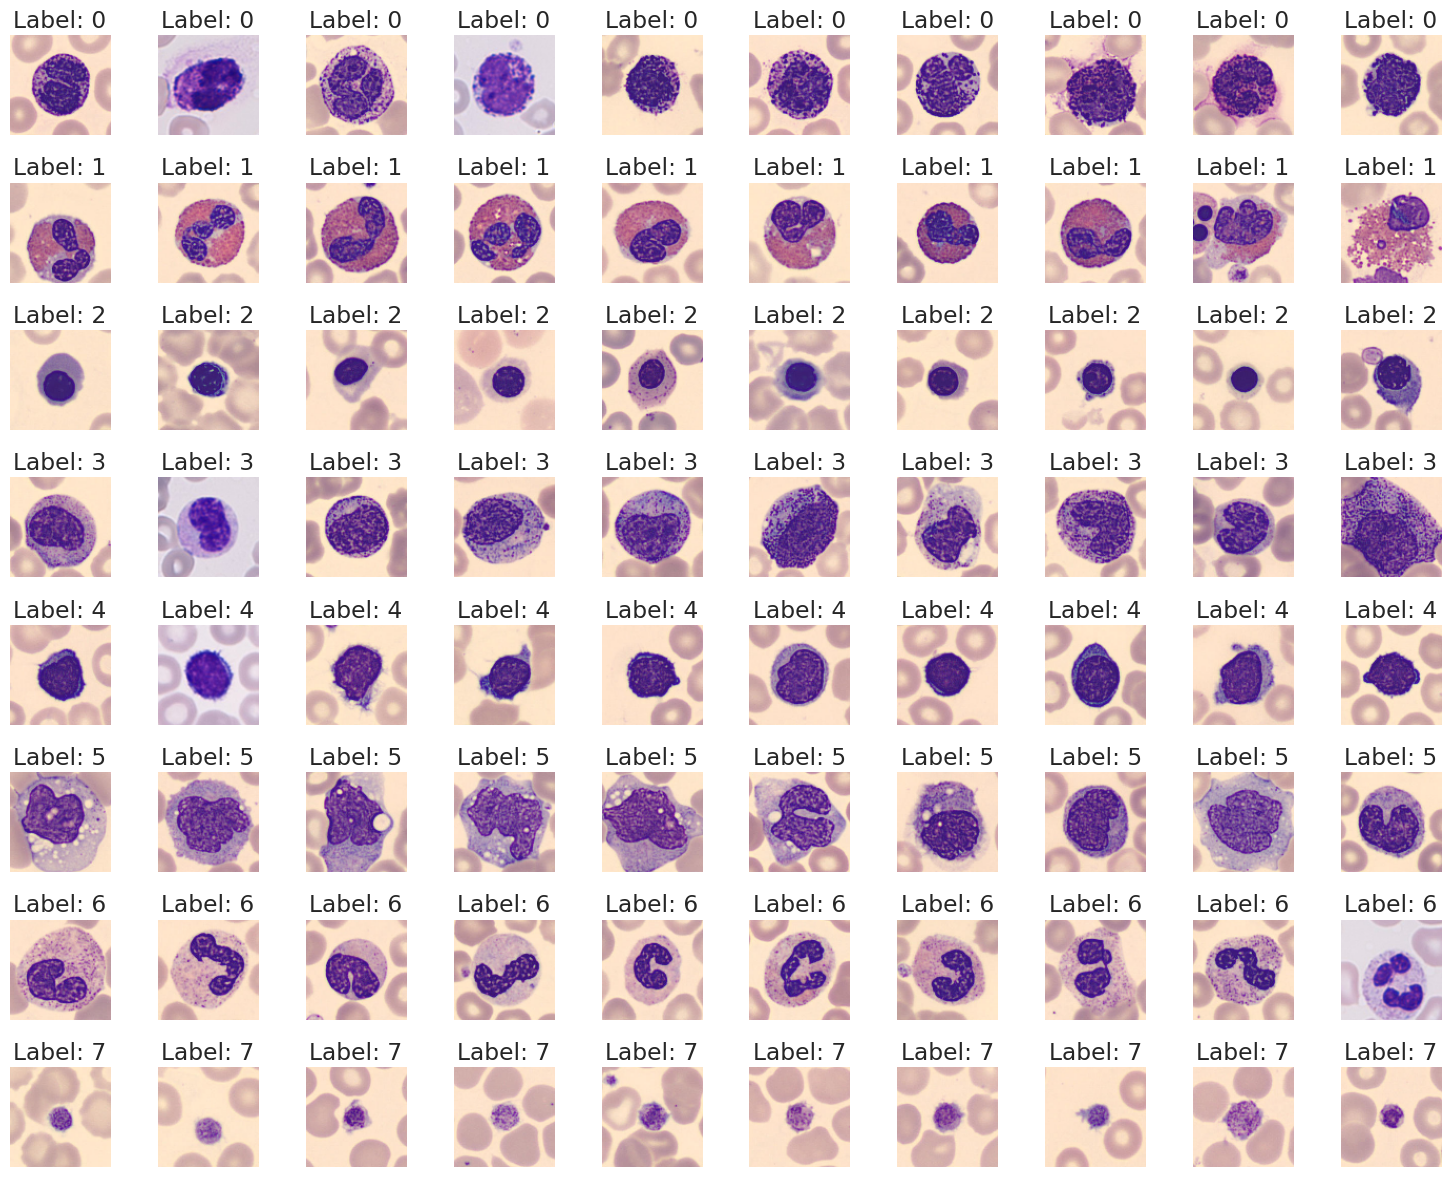

In [ ]:
# Get unique labels
unique_labels = np.unique(labels)  

# Calculate total number of subplots
num_subplots = len(unique_labels) * 10

# Calculate number of rows and columns for the grid
num_cols = 10
num_rows = num_subplots // num_cols
if num_subplots % num_cols != 0:
    num_rows += 1

# Create a single figure and axes with gridspec
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 1.5))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Counter for current subplot
subplot_idx = 0

for label in unique_labels:
    # Find indices of images with the current label
    indices = np.where(labels == label)[0]

    # Randomly select 10 indices
    selected_indices = random.sample(list(indices), 10)

    # Plot the selected images in the corresponding subplots
    for i, idx in enumerate(selected_indices):
        axes[subplot_idx].imshow(images[idx], cmap='gray')
        axes[subplot_idx].set_title(f'Label: {labels[idx][0]}')
        axes[subplot_idx].axis('off')
        subplot_idx += 1

# Hide any unused subplots
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Visualize label distribution in the cleaned training set

Label Distribution:
Label 0: 852 occurrences
Label 1: 2181 occurrences
Label 2: 1084 occurrences
Label 3: 2026 occurrences
Label 4: 849 occurrences
Label 5: 994 occurrences
Label 6: 2330 occurrences
Label 7: 1643 occurrences


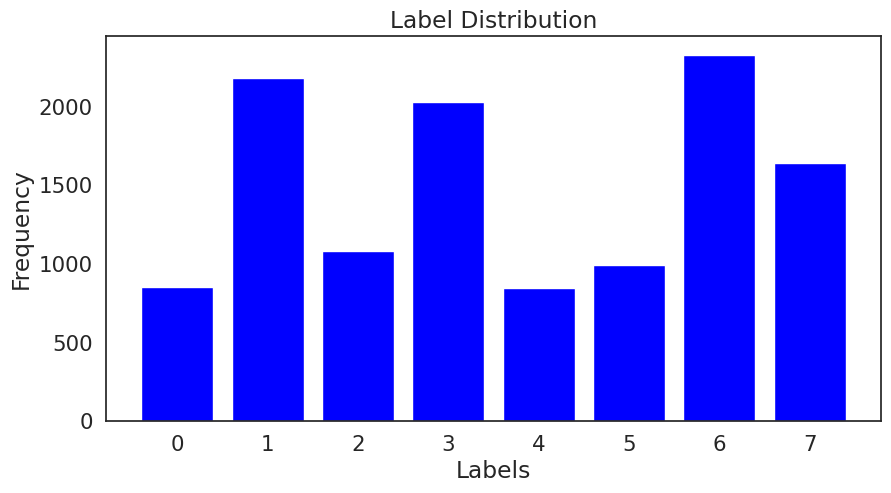

In [8]:
# Prepare label distribution
unique, counts = np.unique(labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
label_names = [label_dict[label] for label in unique]

# Print the label distribution
print("Label Distribution:")
for label, count in label_distribution.items():
    print(f"Label {label_dict[label]}: {count} occurrences")

# Plot the histogram of label distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(label_names, label_distribution.values(), color='skyblue', edgecolor='black')

# Add value annotations on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, str(height), 
             ha='center', va='bottom', fontsize=10, color='black')

# Enhance the aesthetics
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Label Distribution', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to fit elements nicely
plt.show()

# Data preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=seed,
    stratify=labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_val
)

In [26]:
# One hot encoding
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_test = tfk.utils.to_categorical(y_test, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

In [27]:
# Print the shapes of the resulting sets before applying SMOTE
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Training set shape:	 (7653, 96, 96, 3) (7653, 8)
Validation set shape:	 (1914, 96, 96, 3) (1914, 8)
Test set shape:		 (2392, 96, 96, 3) (2392, 8)


# Data augmentation 

In [ ]:
# Define a function to convert images to float32 and normalize them
def process_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image * 255
    return image, label

# Define standard augmentation layers
randomLayers = tfk.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.1),
    ])

# Define custom augmentation layers
random_cutout = keras_cv.layers.RandomCutout(width_factor = 0.5, height_factor = 0.3, fill_value = 0.0)
randAug = keras_cv.layers.RandAugment(value_range=(0, 255), magnitude=0.3)
augmix = keras_cv.layers.AugMix(value_range=(0, 255), severity=0.3)
random_gridmask = keras_cv.layers.GridMask()

# Apply augmentation to the training set with the specified probability
def augment_image(image, label):
    image = randomLayers(image)
    
    if random.random() > 0.5:
        image = random_cutout(image)
    if random.random() > 0.4:
        image = augmix(image)
    elif random.random() > 0.5:
        image = randAug(image)
    if random.random() > 0.3:
        image = random_gridmask(image)
    
    return image, label

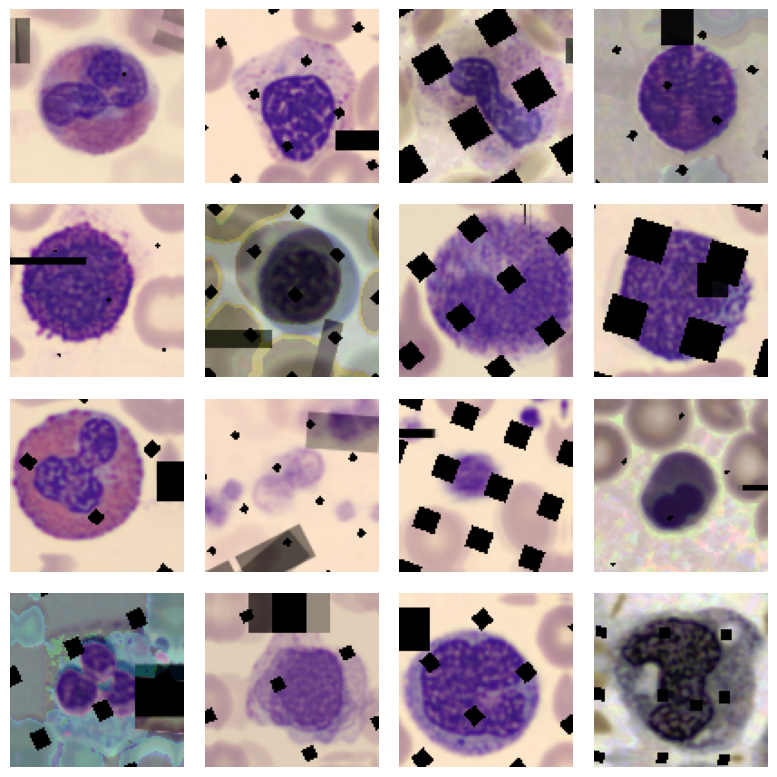

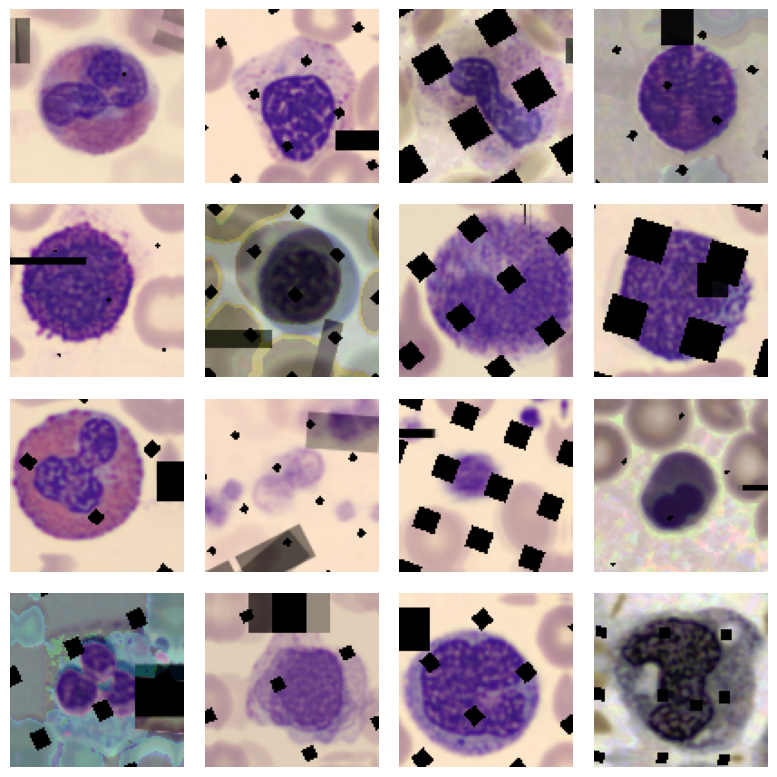

In [ ]:
# Visualize augmented dataset
augmented_visualization_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .take(1)
)

images = next(iter(augmented_visualization_ds.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

In [37]:
# Use class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.7520604395604396,
 1: 0.6852614613180515,
 2: 1.3804112554112553,
 3: 0.737567463377024,
 4: 1.7617403314917126,
 5: 1.5041273584905661,
 6: 0.6415995975855131,
 7: 0.9102045670789725}

# Transfer Learning using EfficientNet

In [38]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
effnet = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling='avg',
    classifier_activation="softmax",
    include_preprocessing=True,
    name="efficientnetv2-s",
)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Freeze all layers in EfficientNetV2S to use it solely as a feature extractor
effnet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the EfficientNetV2S feature extractor
x = effnet(inputs)

# Add batch normalization
x = tf.keras.layers.BatchNormalization(name='batch_norm_1')(x)

# Progressive dropout
x = tfkl.Dropout(0.3, name='dropout_1')(x)
x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005), name='dense_1')(x)

# Output layer
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='output')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=keras_cv.losses.FocalLoss(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['accuracy'])

In [ ]:
# Prepare the dataset for training
batch_size = 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
)

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(process_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size))

In [ ]:
# Train the model
history = tl_model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = 200,
    validation_data = val_ds,
    class_weight=class_weight_dict,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=20,
            restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BloodCells_EfficientNetV2S_eff_TF_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Delete the model to free up resources
del tl_model

Epoch 1/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.6209 - loss: 0.4121 - val_accuracy: 0.6677 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 2/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.6283 - loss: 0.2159 - val_accuracy: 0.6641 - val_loss: 0.1745 - learning_rate: 0.0010
Epoch 3/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.6405 - loss: 0.1762 - val_accuracy: 0.7304 - val_loss: 0.1449 - learning_rate: 0.0010
Epoch 4/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.6387 - loss: 0.1656 - val_accuracy: 0.6714 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 5/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.6401 - loss: 0.1669 - val_accuracy: 0.7189 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 6/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.6266 - loss: 0.1670 - val_accuracy: 0.5684 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 7/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accura

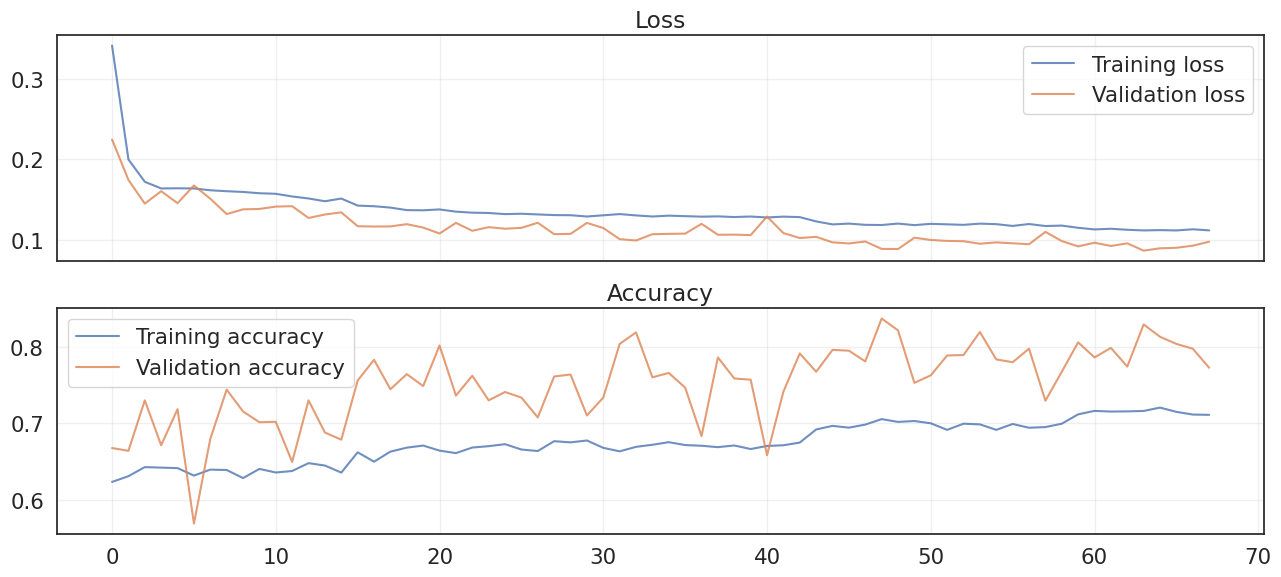

In [45]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.plot(history['loss'], label='Training loss', alpha=.8)
ax1.plot(history['val_loss'], label='Validation loss', alpha=.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=.8)
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## Model evaluation

In [ ]:
# Load the saved model
model = tfk.models.load_model('BloodCells_EfficientNetV2S_eff_TF_83.8.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling (Rescaling)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv (Conv2D)     │ (None, 48, 48, 24)    │        648 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_bn                │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_activation        │ (None, 48, 48, 24)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1a_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1b_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_drop (Dropout) │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_conv    │ (None, 24, 24, 96)    │     20,736 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_bn      │ (None, 24, 24, 96)    │        384 │   N   │
│ (BatchNormalization)        │                       │            │     

 Total params: 21,331,578 (81.37 MB)

 Trainable params: 332,552 (1.27 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

 Optimizer params: 665,106 (2.54 MB)

Test Loss: 0.0872
Test Accuracy: 0.8449
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step
Test Accuracy (sklearn.metrics): 0.8449


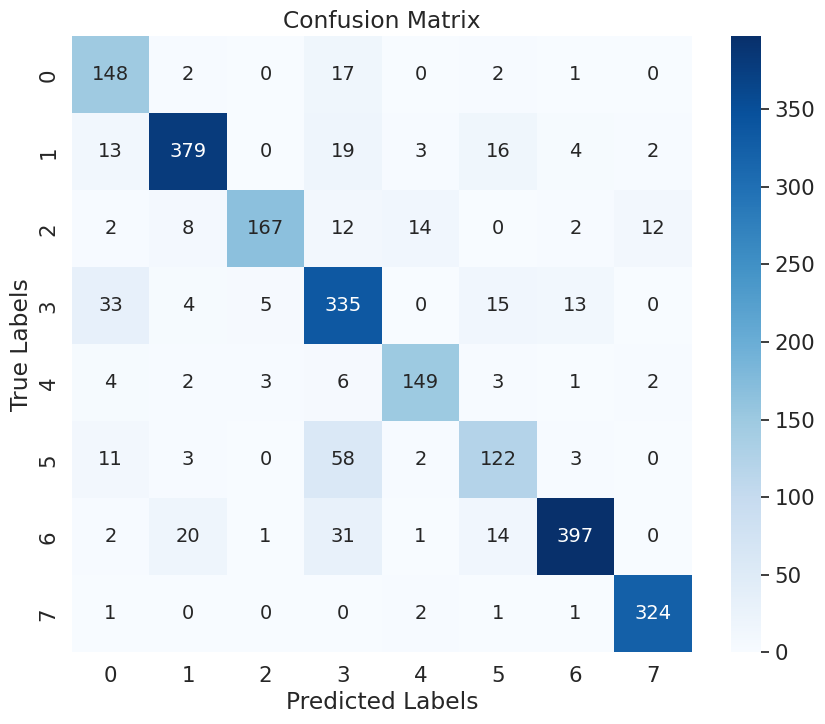

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Map label indices to names
label_names = [label_dict[i] for i in range(len(label_dict))]

# Calculate and print accuracy using sklearn.metrics
y_test_classes = np.argmax(y_test, axis=1)  # Convert y_test to class labels
accuracy_sklearn = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy (sklearn.metrics): {accuracy_sklearn:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Fine tuning

In [49]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('BloodCells_EfficientNetV2S_eff_TF_83.8.keras')

In [50]:
# Set the EfficientNetV2S model layers as trainable
ft_model.get_layer('efficientnetv2-s').trainable = True

# Set all EfficientNetV2S layers as non-trainable
for layer in ft_model.get_layer('efficientnetv2-s').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 stem_conv Conv2D True
5 block1a_project_conv Conv2D True
9 block1b_project_conv Conv2D True
14 block2a_expand_conv Conv2D True
17 block2a_project_conv Conv2D True
19 block2b_expand_conv Conv2D True
22 block2b_project_conv Conv2D True
26 block2c_expand_conv Conv2D True
29 block2c_project_conv Conv2D True
33 block2d_expand_conv Conv2D True
36 block2d_project_conv Conv2D True
40 block3a_expand_conv Conv2D True
43 block3a_project_conv Conv2D True
45 block3b_expand_conv Conv2D True
48 block3b_project_conv Conv2D True
52 block3c_expand_conv Conv2D True
55 block3c_project_conv Conv2D True
59 block3d_expand_conv Conv2D True
62 block3d_project_conv Conv2D True
66 block4a_expand_conv Conv2D True
69 block4a_dwconv2 DepthwiseConv2D True
74 block4a_se_reduce Conv2D True
75 block4a_se_expand Conv2D True
77 block4a_project_conv Conv2D True
79 block4b_expand_conv Conv2D True
82 block4b_dwconv2 DepthwiseConv2D True
87 block4b_se_reduce Conv2D True
88 block4b_se_expand Conv2D True
90 block4b_project_c

In [51]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    print(i, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv False
3

In [53]:
# Compile the model
ft_model.compile(loss=keras_cv.losses.FocalLoss(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [54]:
# Fine-tune the model
ft_history = ft_model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = 200,
    validation_data = val_ds,
    class_weight=class_weight_dict,
    callbacks=[
        tfk.callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=20,
            restore_best_weights=True
        ),
        tfk.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7
        )
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'BloodCells_EfficientNetV2S_FT_eff_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200


E0000 00:00:1731665781.320850     699 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731665781.508467     699 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731665781.889293     699 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731665782.086679     699 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731665782.677514     699 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7776 - loss: 0.1008

E0000 00:00:1731665851.095890     700 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731665851.297601     700 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


240/240 ━━━━━━━━━━━━━━━━━━━━ 161s 345ms/step - accuracy: 0.7780 - loss: 0.1007 - val_accuracy: 0.9368 - val_loss: 0.0428 - learning_rate: 1.0000e-04
Epoch 2/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.8856 - loss: 0.0663 - val_accuracy: 0.9378 - val_loss: 0.0406 - learning_rate: 1.0000e-04
Epoch 3/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9088 - loss: 0.0543 - val_accuracy: 0.9227 - val_loss: 0.0532 - learning_rate: 1.0000e-04
Epoch 4/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.9190 - loss: 0.0491 - val_accuracy: 0.9540 - val_loss: 0.0341 - learning_rate: 1.0000e-04
Epoch 5/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.9299 - loss: 0.0422 - val_accuracy: 0.9065 - val_loss: 0.0628 - learning_rate: 1.0000e-04
Epoch 6/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.9276 - loss: 0.0431 - val_accuracy: 0.9702 - val_loss: 0.0230 - learning_rate: 1.0000e-04
Epoch 7/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/

## Model evaluation

In [ ]:
# Load the saved model
model = tfk.models.load_model('BloodCells_EfficientNetV2S_FT_eff_99.16.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ rescaling (Rescaling)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_conv (Conv2D)     │ (None, 48, 48, 24)    │        648 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_bn                │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ stem_activation        │ (None, 48, 48, 24)    │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1a_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1a_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_conv   │ (None, 48, 48, 24)    │      5,184 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_project_bn     │ (None, 48, 48, 24)    │         96 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 24)    │          0 │   -   │
│ block1b_project_activation  │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_drop (Dropout) │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block1b_add (Add)      │ (None, 48, 48, 24)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_conv    │ (None, 24, 24, 96)    │     20,736 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ block2a_expand_bn      │ (None, 24, 24, 96)    │        384 │   N   │
│ (BatchNormalization)        │                       │            │     

 Total params: 58,445,834 (222.95 MB)

 Trainable params: 18,889,680 (72.06 MB)

 Non-trainable params: 1,776,792 (6.78 MB)

 Optimizer params: 37,779,362 (144.12 MB)

Test Loss: 0.0091
Test Accuracy: 0.9858
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step
Test Accuracy (sklearn.metrics): 0.9858


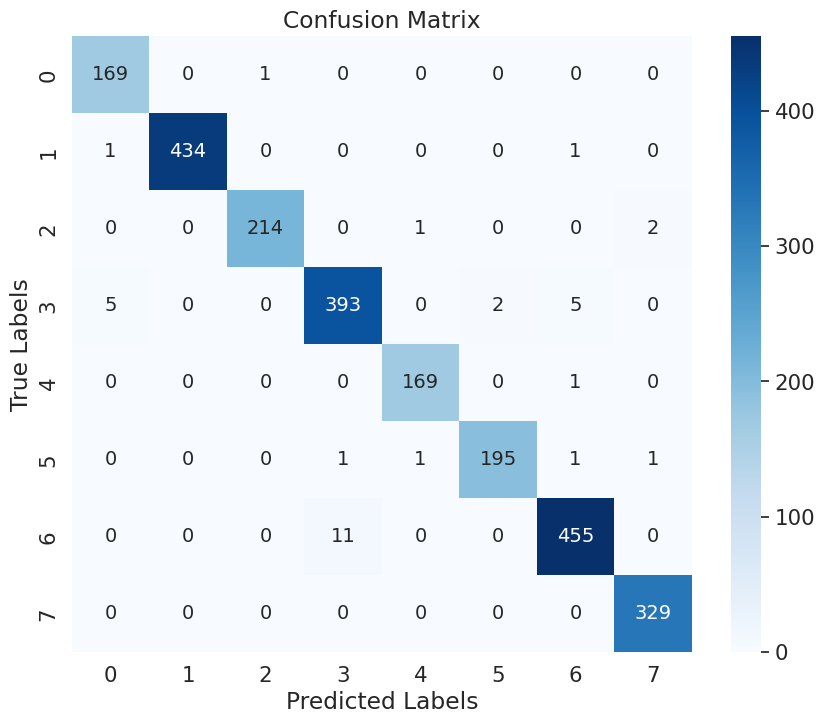

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Map label indices to names
label_names = [label_dict[i] for i in range(len(label_dict))]

# Calculate and print accuracy using sklearn.metrics
y_test_classes = np.argmax(y_test, axis=1)  # Convert y_test to class labels
accuracy_sklearn = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy (sklearn.metrics): {accuracy_sklearn:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=[str(i) for i in unique_labels])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       170
           1       1.00      1.00      1.00       436
           2       1.00      0.99      0.99       217
           3       0.97      0.97      0.97       405
           4       0.99      0.99      0.99       170
           5       0.99      0.98      0.98       199
           6       0.98      0.98      0.98       466
           7       0.99      1.00      1.00       329

    accuracy                           0.99      2392
   macro avg       0.99      0.99      0.99      2392
weighted avg       0.99      0.99      0.99      2392



# Save model

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py BloodCells_EfficientNetV2S_FT_eff_99.16.keras

  adding: model.py (deflated 54%)
  adding: BloodCells_EfficientNetV2S_FT_eff_99.16.keras (deflated 8%)
